# Imports

In [1]:
!nvidia-smi

Tue Oct 24 09:51:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   31C    P8    25W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.__version__

'1.12.1+cu116'

In [3]:
!pip install -U albumentations[imgaug]

  Using cached opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.1 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 3.4.18.65
    Uninstalling opencv-python-headless-3.4.18.65:
      Successfully uninstalled opencv-python-headless-3.4.18.65


In [4]:
!pip -q install timm
!pip -q install efficientnet_pytorch
!pip -q install albumentations --upgrade
!pip install "opencv-python-headless<4.3"
#!pip install opencv

  Using cached opencv_python_headless-3.4.18.65-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.7 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.


In [5]:
# %%capture
# !git clone https://github.com/NVIDIA/apex
# !cd apex && pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [6]:
use_apex = False

try:
    from apex import amp as apex_amp
    use_apex = True
except ImportError:
    pass

use_apex

False

In [7]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch
import timm
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import numpy as np
import albumentations as A
from torch.nn import Module,Sequential
import gc
import cv2
from albumentations.augmentations.transforms import Lambda
import IPython.display as ipd
import requests
import io
import urllib.parse

In [8]:
import random
import numpy as np
SEED_VAL  = 1000
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED = SEED_VAL):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
  torch.backends.cudnn.deterministic = True

In [9]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

# CONF

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class conf:
  train_batch_size = 48
  learning_rate = 2e-3
  model_name = 'tf_efficientnetv2_m.in21k_ft_in1k'
  num_classes = 1
  epochs = 25
  nfolds = 5
  use_folds = [0,1,2,3,4]
  use_finetuned = False
  path_model = "*"
  use_tta = False
  tta_iterations = 5
  use_scheduler = True
  workers = os.cpu_count()
def get_default_conf():
    return conf

CONF = get_default_conf()

# Donwload Data and Read it

In [11]:
# Read in csv files.
main_path = "/storage/cgiar-eyes-data/"
train = pd.read_csv(main_path+'/Train.csv')
test = pd.read_csv(main_path+'/Test.csv')
sample_submission = pd.read_csv(main_path+'/SampleSubmission.csv')
train.shape,test.shape

((26068, 6), (8663, 5))

In [12]:
train.head()

,ID,filename,growth_stage,damage,extent,season
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020
3,ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020
4,ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021


In [13]:
train.extent.value_counts()

0      21558
10       729
30       727
40       696
20       690
50       445
60       388
90       300
80       291
70       199
100       45
Name: extent, dtype: int64

In [14]:
train.season.value_counts(normalize=True)

SR2021    0.380812
LR2021    0.304780
SR2020    0.236420
LR2020    0.077988
Name: season, dtype: float64

In [15]:
test.head()

,ID,filename,growth_stage,damage,season
0,ID_ROOWKB90UZ,L122F00315C01S02151Rp04021.jpg,V,WD,SR2020
1,ID_PTEDRY0CYM,L1089F03254C01S08845Rp25119.jpg,F,WD,LR2021
2,ID_5WJXDV96R4,L365F01913C39S12578Rp42918.jpg,V,WD,SR2021
3,ID_DM4AQLXXYG,223_repeat_2_2230_3599_2343.JPG,F,G,LR2020
4,ID_V6YTIT7I2S,L354F00276C01S08045Rp23693.jpg,F,G,LR2021


In [16]:
test.season.value_counts(normalize=True)

SR2021    0.372042
LR2021    0.308784
SR2020    0.239294
LR2020    0.079880
Name: season, dtype: float64

In [17]:
sample_submission.head()

,ID,extent
0,ID_KJ12GE2U80,0
1,ID_W33POE3DBX,0
2,ID_1DZ7VKQTS9,0
3,ID_BAA59RN8RS,0
4,ID_45QA45VTEJ,0


In [18]:
train.shape, test.shape, sample_submission.shape

((26068, 6), (8663, 5), (8663, 2))

# Cross Validate

In [19]:
def cross_validate(train_orig,nfolds=CONF.nfolds):
  train = train_orig.copy()
  train['kfold'] = -1
  #get only 30 new turtle ( can add costraint of number images >= x , 10 for example)
  skf = StratifiedKFold(CONF.nfolds,random_state=SEED_VAL,shuffle=True)
  label_split = train[['growth_stage', 'season', 'extent']].apply(lambda x: '_'.join(list(map(str, x))), axis=1)
  for i,(train_index,val_index) in enumerate(skf.split(train,y=label_split)):
    train.loc[val_index,'kfold'] = i
  return train

In [20]:
train = cross_validate(train)
train.head()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,ID,filename,growth_stage,damage,extent,season,kfold
0,ID_1S8OOWQYCB,L427F01330C01S03961Rp02052.jpg,S,WD,0,SR2020,1
1,ID_0MD959MIZ0,L1083F00930C39S12674Ip.jpg,V,G,0,SR2021,0
2,ID_JRJCI4Q11V,24_initial_1_1463_1463.JPG,V,G,0,LR2020,3
3,ID_DBO3ZGI1GM,L341F00167C01S00324Rp14178.jpg,M,DR,60,SR2020,4
4,ID_ORZLWTEUUS,L1084F02394C39S13931Ip.jpg,V,G,0,SR2021,1


In [21]:
train[train.kfold == 0].extent.mean(),train[train.kfold == 1].extent.mean()

(7.0694284618335255, 7.061756808592252)

In [22]:
# train.extent = (train.extent * 10 ).astype('int')
# train.extent.value_counts()

# Modeling

In [23]:
import cv2
def default_image_loader(path):
    return Image.open(path).convert('RGB')

def cv_reader(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

class ImageDataset(Dataset):
    def __init__(self, data_path, df, transform=None,mode='train'):
        self.df = df
        self.loader = cv_reader
        self.transform = transform
        self.dir = data_path
        self.mode = mode

    def __getitem__(self, index):
        image_id = self.df.filename[index]
        image = self.loader(os.path.join(self.dir, image_id))
        if self.transform is not None:
          image = self.transform(image=image)
          image=image["image"]


        if self.mode == 'train':
            label = self.df.extent[index]
            return {'image' : torch.tensor(image,dtype=torch.float),
                'label' : torch.tensor(label,dtype = torch.float) }

        return {'image' : torch.tensor(image,dtype=torch.float),
}


    def __len__(self):
        return self.df.shape[0]

In [24]:
class Net(nn.Module):
    def __init__(self,name,NUM_CLASSES):
        super(Net, self).__init__()
        self.name  = name
        if name == 'b0':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b0')
          self.arch._fc = nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True)
        elif name == 'b1':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b1')
          self.arch._fc = nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True)
        elif name == 'b2':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b2')
          self.arch._fc = nn.Linear(in_features=1408, out_features=NUM_CLASSES, bias=True)
        elif name =='b3':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b3')
          self.arch._fc = nn.Linear(in_features=1536, out_features=NUM_CLASSES, bias=True)
        elif name =='b4':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b4')
          self.arch._fc = nn.Linear(in_features=1792, out_features=NUM_CLASSES, bias=True)
        elif name =='b5':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b5')
          self.arch._fc = nn.Linear(in_features=2048, out_features=NUM_CLASSES, bias=True)
        elif name =='b6':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b6')
          self.arch._fc = nn.Linear(in_features=2304, out_features=NUM_CLASSES, bias=True)
        elif name =='b7':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b7')
          self.arch._fc = nn.Linear(in_features=2560, out_features=NUM_CLASSES, bias=True)
        elif name=='efficientnetv2_rw_m':
          self.arch = timm.create_model(name,pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'densenet121':
          self.arch = models.densenet121(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'densenet169':
          self.arch = models.densenet169(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'densenet201':
          self.arch = models.densenet201(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet18':
          self.arch = models.resnet18(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet50':
          self.arch = models.resnet50(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet101':
          self.arch = models.resnet101(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet152':
          self.arch = models.resnet152(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnet34':
          self.arch = models.resnet34(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnext101':
          self.arch = models.resnext101_32x8d(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif name == 'resnext50':
          self.arch = models.resnext50_32x4d(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif 'swin' in name:
          self.arch = timm.create_model(name,pretrained=True)
          num_ftrs = self.arch.head.in_features
          self.arch.head = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        elif 'convnext' in name:
          self.arch = timm.create_model(name,pretrained=True)
          num_ftrs = self.arch.head.fc.in_features
          self.arch.head.fc = nn.Linear(num_ftrs,NUM_CLASSES,bias=True)
        else:
          self.arch  = timm.create_model(name, num_classes=1, pretrained=True)

    def forward(self, x):
        """
        """
        x = self.arch(x)
        return x

In [25]:
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def loss_fn(outputs,targets):
  criterion =  torch.nn.MSELoss()
  return criterion(outputs,targets)

In [27]:
!pip -q install accelerate
from accelerate import Accelerator

In [28]:
def train_fn(train_data_loader,model,optimizer,device,accelerator,scheduler):
  model.train()
  tot_loss = 0
  loss_meter = AverageMeter()
  tepoch = tqdm(enumerate(train_data_loader),total=len(train_data_loader))
  for bi,d in tepoch:
    images = d['image']
    labels = d['label']

    #send them to device
    # images = images.to(device,dtype=torch.float)
    # labels = labels.to(device,dtype=torch.float)
    outputs  = model(torch.permute(images,(0,3,1,2)))
    outputs = outputs.reshape(outputs.size()[0])
    loss = loss_fn(outputs,labels)
    if use_apex:
      with apex_amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
    else:
      accelerator.backward(loss)
#     loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_meter.update(loss.item())
    tepoch.set_postfix(average_rmse=np.sqrt(loss_meter.avg))
    tot_loss = tot_loss + loss.item()
    if scheduler is not None:
        scheduler.step()
  mse_score = tot_loss/len(train_data_loader)
  return np.sqrt(mse_score)

def eval_fn(valid_data_loader,model,device):
  model.eval()
  tot_loss = 0
  all_outputs = []
  all_labels = []
  with torch.no_grad():
    for bi,d in enumerate(valid_data_loader):
      images = d['image']
      labels = d['label']
      #send them to device
      # images = images.to(device,dtype=torch.float)
      # labels = labels.to(device,dtype=torch.float)
      outputs  = model(torch.permute(images,(0,3,1,2)))
      outputs = outputs.reshape(outputs.size()[0])
      all_outputs.extend(outputs.detach().cpu().numpy())
      all_labels.extend(labels.detach().cpu().numpy())
      loss = loss_fn(outputs,labels)
      tot_loss = tot_loss + loss.item()

    all_outputs = np.array(all_outputs)
    mse_score  = tot_loss/len(valid_data_loader)
    return np.sqrt(mse_score)

In [29]:
HEIGHT = 384
WIDTH = 384
def get_transforms():
    train_transform = A.Compose(
        [
            #CustomAlbImageCropTransform(xmin=0.1, ymin=0.1, xmax=0.9, ymax=0.9, p=0.6),
            #A.Normalize(),
            A.Resize(height=HEIGHT, width=WIDTH, p=1),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ), 
            A.CoarseDropout(
                min_holes=1,
                max_holes=4,
                max_height=0.25,
                max_width=0.25,
                min_height=0.15,
                min_width=0.15,
                p = 0.25,
            ),
            A.Flip(p=0.25),
            A.RandomRotate90(p=0.25),
            A.Blur(p=0.1),
            # A.OneOf([
            #     A.RandomBrightnessContrast(p=1),
            #     A.RandomBrightness(p=1),
            #     A.HueSaturationValue(p=1),
            #     A.GaussianBlur(p=1),
            #     A.Blur(p=1),
            #     A.Sharpen(p=1),
            # ],p=0.2)
            
            #A.Sharpen(p=0.2),
            
#             A.OneOf([
#                 A.Blur(p=1),
#                 A.MedianBlur(p=1, blur_limit=5),
#                 A.GaussianBlur(p=1),
#                 A.GaussNoise(p=1),
#                 A.IAAAdditiveGaussianNoise(p=1),
#             ], p = 0.7),
#             A.OneOf([
#                 A.ColorJitter(p=1),
#                 A.RandomContrast(p=1),
#                 A.RandomGamma(p=1),
#                 A.RandomBrightness(p=1),
#             ], p = 0.7),
#             A.OneOf([
#                 A.ChannelShuffle(p=1),
#                 A.HueSaturationValue(p=1),
#                 A.JpegCompression(p=1),
#                 A.RGBShift(p=1),
#                 A.ToGray(p=1)
#             ], p = 0.55),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.3),
#                 A.GridDistortion(p=0.1),
#                 A.IAAPiecewiseAffine(p=0.3),
#             ], p=0.2),
#             A.OneOf([
#                 A.CLAHE(clip_limit=2),
#                 A.IAASharpen(),
#                 A.IAAEmboss(),
#                 A.RandomBrightnessContrast(),
#             ], p=0.3),
        ],
        p=1.0,
    )

    val_transform = A.Compose([
      A.Resize(HEIGHT,WIDTH),
      A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
      ])

    return train_transform,val_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label[1]: 0.0
25


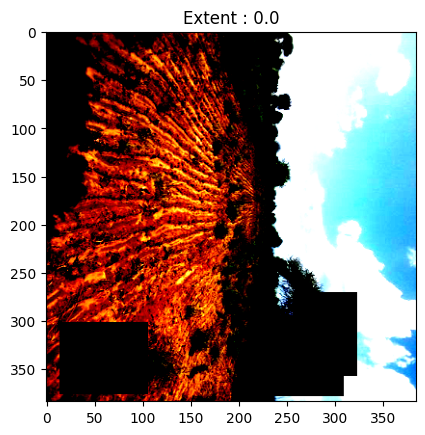

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


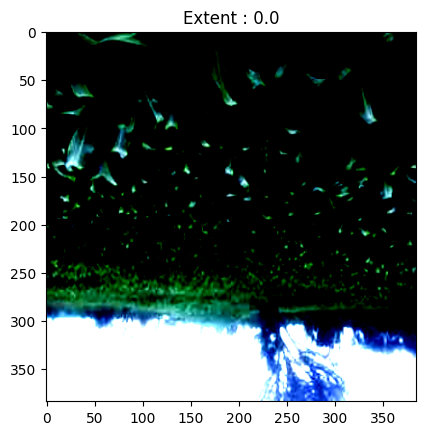

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


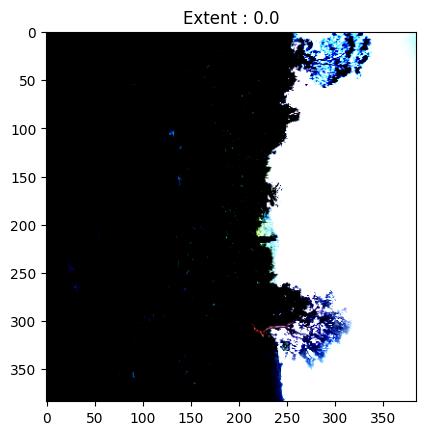

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


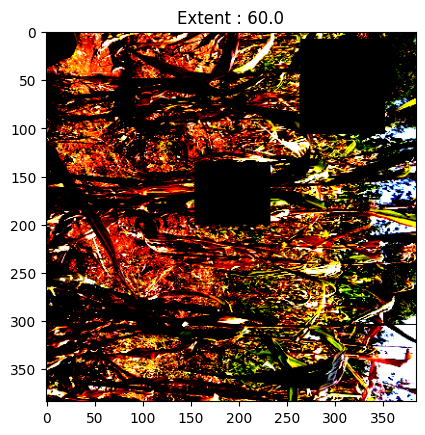

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


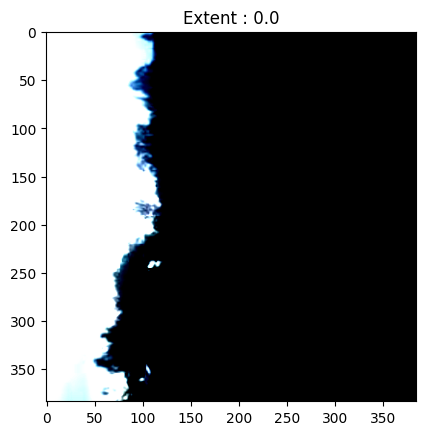

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


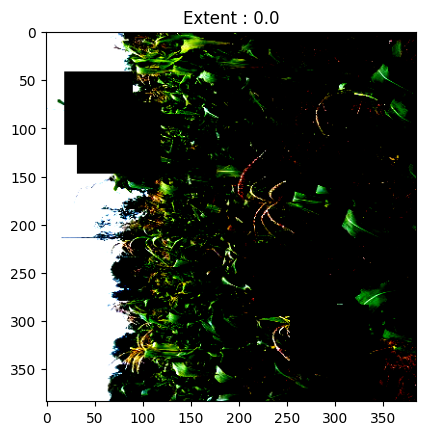

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


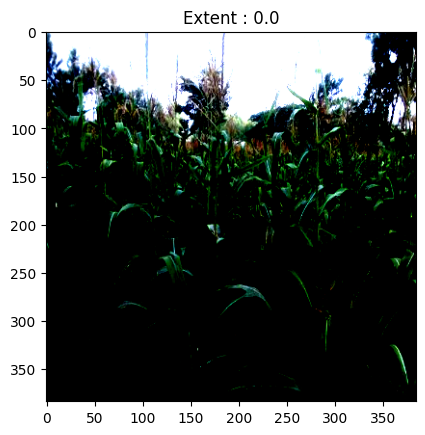

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


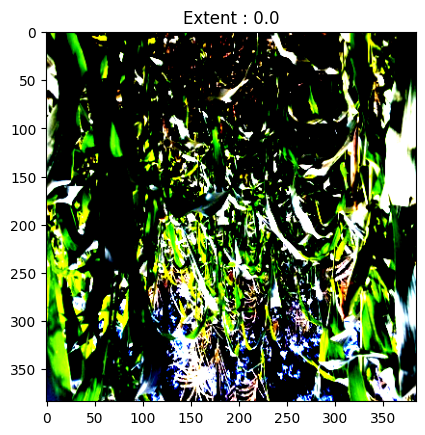

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


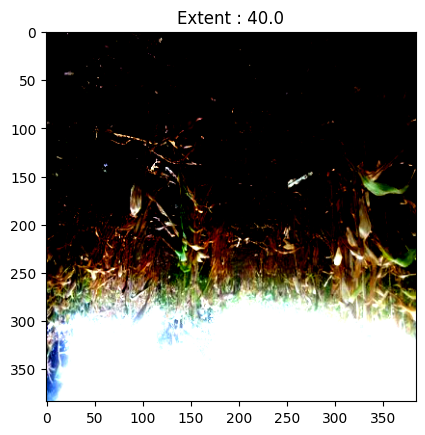

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


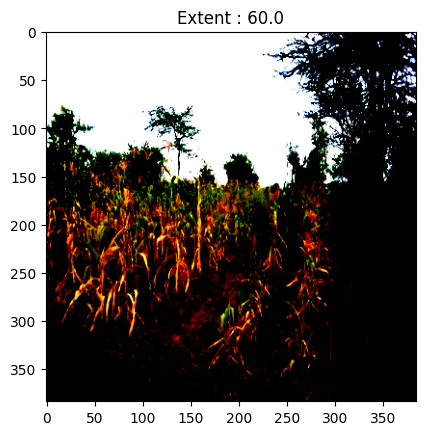

In [30]:
def image_show(data_loader,n):

  #Read Augmented image data
  a = next(iter(data_loader))
  #Convert image from tensor to numpy
  images = a['image'].numpy()
  labels = a['label'].numpy()
  print('label[1]:',labels[1])
  print(len(images))
  #Take out n images one by one and display them
  for i in range(n):
    image = images[i]
    image = np.transpose(image,[0,1,2])
    plt.imshow(image)
    plt.title(f'Extent : {labels[i]}')
    plt.show()


train_transform,_ = get_transforms()
test_images_dataset =  ImageDataset(main_path+'/train',train.head(50).reset_index(drop=True),train_transform)
test_images_loader = DataLoader(dataset=test_images_dataset,shuffle=False,batch_size=25)
image_show(test_images_loader,10)

In [31]:
def get_pretrained():
  model = timm.create_model(CONF.model_name,pretrained=False)
  in_features = model.head.in_features
  model.head =  nn.Linear(in_features, 512)
  model.load_state_dict(torch.load(CONF.path_model))
  model = nn.Sequential(
    model,
    nn.Linear(512,CONF.num_classes)
  )
  return model

In [32]:
train[train.extent==0].sample(frac=1).head(10)

,ID,filename,growth_stage,damage,extent,season,kfold
22627,ID_2Q7NG5V24B,L133F00087C01S02744Rp07616.jpg,F,G,0,SR2020,3
14900,ID_XDRPK8NMKY,L371F03064C01S05069Rp05833.jpg,S,WD,0,SR2020,0
15995,ID_AXE1YX3KAY,L354F00296C39S00000Ip.jpg,V,WD,0,SR2021,2
15387,ID_EDCYZ0ZT3X,L361F02348C01S03587Rp11041.jpg,V,G,0,SR2020,1
20717,ID_JAJ19MU584,L321F01949C01S05642Rp03941.jpg,V,WD,0,SR2020,2
4393,ID_2F431PIHSH,L113F02448C01S04782Rp08588.jpg,V,G,0,SR2020,3
16975,ID_68YDAKKFJS,206_repeat_2_2370_5314_3674.JPG,M,ND,0,LR2020,2
24284,ID_PFDSKILGCU,L371F03158C39S13699Rp35270.jpg,S,G,0,SR2021,0
5707,ID_4ACUARJHV0,L222F00961C01S03356Rp09180.jpg,F,WD,0,SR2020,3
23702,ID_0BSJKGU8K8,L361F02346C01S03584Ip.jpg,V,G,0,SR2020,1


In [33]:
all_scores = []
def run_folds(train):
  seed_all(SEED_VAL)
  train_transform,val_transform = get_transforms()
  for i in CONF.use_folds:
    print(f"#########################  Fold {i+1}/{CONF.nfolds}  #########################")
    if i in range(CONF.nfolds):
      train_df , valid_df = train[train.kfold!=i],train[train.kfold==i]
      # train_df = pd.concat([train_df[train_df.extent==0].sample(frac=1).head(2000),train_df[train_df.extent!=0]])
      train_df = train_df.reset_index()
      print(train_df.extent.value_counts())
      valid_df = valid_df.reset_index()

      train_dataset = ImageDataset(main_path+'/train',train_df,train_transform)
      valid_dataset = ImageDataset(main_path+'/train',valid_df,val_transform)

      train_data_loader = DataLoader(dataset=train_dataset,shuffle=True,batch_size=CONF.train_batch_size,num_workers=CONF.workers,pin_memory=True)
      valid_data_loader = DataLoader(dataset=valid_dataset,shuffle=False,batch_size=32,num_workers=CONF.workers,pin_memory=True)

        
      if CONF.use_finetuned:
        print('haha')
        model = get_pretrained()
      else:
        model = Net(CONF.model_name,CONF.num_classes)

      optimizer = torch.optim.AdamW(model.parameters(), lr=CONF.learning_rate)
      accelerator = Accelerator(mixed_precision='fp16')
      num_train_steps = int(len(train_data_loader) * CONF.epochs)
      #scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.8,min_lr=1e-6,verbose=True)
      scheduler = CosineAnnealingLR(optimizer, T_max=num_train_steps, eta_min=1e-6)
      if use_apex:
            pass
#           model = model.to(device)
#           train_data_loader, valid_data_loader = accelerator.prepare(train_data_loader, valid_data_loader)
#           model, optimizer = apex_amp.initialize(model, optimizer, opt_level='O1')
      else:
        if CONF.use_scheduler:
            model, optimizer, train_data_loader, valid_data_loader,scheduler = accelerator.prepare(model, optimizer, train_data_loader, valid_data_loader,scheduler)
        else:
            model, optimizer, train_data_loader, valid_data_loader = accelerator.prepare(model, optimizer, train_data_loader, valid_data_loader)


      best_mse = 1500
      for epoch in range(CONF.epochs):
        print(f"----------------FOLD {i+1} : EPOCH {epoch+1}---------------------")
        mse_train = train_fn(train_data_loader, model, optimizer, device,accelerator,scheduler=scheduler)
        mse_val = eval_fn(valid_data_loader ,model, device)
        print(f"train_loss: {mse_train} ### val_loss: {mse_val}")
        if mse_val<best_mse:
          best_mse = mse_val
          torch.save(model.state_dict(),f"best_model_{i}")

      all_scores.append(best_mse)
      print(f'best VAL_LOGLOSS for fold {i+1}: ',best_mse)
    else:
      pass
  print(f"MEAN over all FOLDS: {np.mean(all_scores)}")
  return np.mean(all_scores)

In [34]:
use_apex

False

In [ ]:
sc = run_folds(train)

#########################  Fold 1/5  #########################
0      17245
30       585
10       581
40       558
20       551
50       354
60       311
90       241
80       233
70       159
100       36
Name: extent, dtype: int64
----------------FOLD 1 : EPOCH 1---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 15.64572804773157 ### val_loss: 13.25538235118245
----------------FOLD 1 : EPOCH 2---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.858553493496233 ### val_loss: 12.99321613478681
----------------FOLD 1 : EPOCH 3---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.464996406366511 ### val_loss: 14.446250504928193
----------------FOLD 1 : EPOCH 4---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.287008730738764 ### val_loss: 12.199649922284793
----------------FOLD 1 : EPOCH 5---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.30828973083204 ### val_loss: 12.566540966578629
----------------FOLD 1 : EPOCH 6---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.942075273784786 ### val_loss: 12.001268804157547
----------------FOLD 1 : EPOCH 7---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.942765742812714 ### val_loss: 12.621552425582035
----------------FOLD 1 : EPOCH 8---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.661321757239534 ### val_loss: 12.447568260098407
----------------FOLD 1 : EPOCH 9---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.445942473655704 ### val_loss: 12.433330017599541
----------------FOLD 1 : EPOCH 10---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.346190183945879 ### val_loss: 11.697307581198181
----------------FOLD 1 : EPOCH 11---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.005154293807154 ### val_loss: 12.024282189377972
----------------FOLD 1 : EPOCH 12---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.655002608713382 ### val_loss: 11.704208229530016
----------------FOLD 1 : EPOCH 13---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.552952999733112 ### val_loss: 12.918010665100123
----------------FOLD 1 : EPOCH 14---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.952159390412062 ### val_loss: 12.193693617954807
----------------FOLD 1 : EPOCH 15---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.461876225979688 ### val_loss: 12.419249769542565
----------------FOLD 1 : EPOCH 16---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.033083236831029 ### val_loss: 11.763110746187618
----------------FOLD 1 : EPOCH 17---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 9.43268951776103 ### val_loss: 12.000880563910387
----------------FOLD 1 : EPOCH 18---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.90678556425488 ### val_loss: 11.866300147506161
----------------FOLD 1 : EPOCH 19---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.732442118757618 ### val_loss: inf
----------------FOLD 1 : EPOCH 20---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.381430503879484 ### val_loss: 11.88558722492108
----------------FOLD 1 : EPOCH 21---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.98158553894974 ### val_loss: 11.691268398853754
----------------FOLD 1 : EPOCH 22---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.6903337954846505 ### val_loss: 11.628897563966671
----------------FOLD 1 : EPOCH 23---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.611794756949929 ### val_loss: 11.6850606231056
----------------FOLD 1 : EPOCH 24---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.432418279529044 ### val_loss: 11.76679378428471
----------------FOLD 1 : EPOCH 25---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.486947438737785 ### val_loss: 11.674140701561374
best VAL_LOGLOSS for fold 1:  11.628897563966671
#########################  Fold 2/5  #########################
0      17245
10       582
30       581
40       557
20       552
50       357
60       310
90       240
80       233
70       160
100       37
Name: extent, dtype: int64
----------------FOLD 2 : EPOCH 1---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 16.66300636779475 ### val_loss: 14.010607700981408
----------------FOLD 2 : EPOCH 2---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.677669294721463 ### val_loss: 13.15011304966792
----------------FOLD 2 : EPOCH 3---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.36289808349478 ### val_loss: 12.869493425163558
----------------FOLD 2 : EPOCH 4---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.217482452931279 ### val_loss: 12.539676993470524
----------------FOLD 2 : EPOCH 5---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.106368346860805 ### val_loss: 12.249071202303831
----------------FOLD 2 : EPOCH 6---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.02516878500799 ### val_loss: 12.348495746358381
----------------FOLD 2 : EPOCH 7---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.77039346703681 ### val_loss: 12.732176328642776
----------------FOLD 2 : EPOCH 8---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.597112595505772 ### val_loss: 13.102306454407696
----------------FOLD 2 : EPOCH 9---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.426154986574504 ### val_loss: 12.145480413787332
----------------FOLD 2 : EPOCH 10---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.159847433081593 ### val_loss: 12.789339451877128
----------------FOLD 2 : EPOCH 11---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.144201118841968 ### val_loss: 11.811145965766778
----------------FOLD 2 : EPOCH 12---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.526671737518436 ### val_loss: 11.961454246295979
----------------FOLD 2 : EPOCH 13---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.281389822831118 ### val_loss: 11.795606533819308
----------------FOLD 2 : EPOCH 14---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.873950774079766 ### val_loss: 11.827491577895286
----------------FOLD 2 : EPOCH 15---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.334307298527055 ### val_loss: 11.809728815899932
----------------FOLD 2 : EPOCH 16---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 9.833469082519406 ### val_loss: 11.96661974198362
----------------FOLD 2 : EPOCH 17---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 9.386486139180233 ### val_loss: 12.152259688177823
----------------FOLD 2 : EPOCH 18---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.94009049263629 ### val_loss: 11.887553786556063
----------------FOLD 2 : EPOCH 19---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.465674729820936 ### val_loss: 12.038567535319068
----------------FOLD 2 : EPOCH 20---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.245127795401189 ### val_loss: 11.91491461877021
----------------FOLD 2 : EPOCH 21---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.784404640734692 ### val_loss: 11.873841925600601
----------------FOLD 2 : EPOCH 22---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.546637720048295 ### val_loss: 11.889430616093833
----------------FOLD 2 : EPOCH 23---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.151050276787469 ### val_loss: 11.922040699686198
----------------FOLD 2 : EPOCH 24---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.108953248206054 ### val_loss: 11.969359771423264
----------------FOLD 2 : EPOCH 25---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.211317690180929 ### val_loss: 11.904541847151522
best VAL_LOGLOSS for fold 2:  11.795606533819308
#########################  Fold 3/5  #########################
0      17246
10       584
30       581
40       556
20       553
50       356
60       311
90       240
80       234
70       159
100       34
Name: extent, dtype: int64
----------------FOLD 3 : EPOCH 1---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 17.068694585042643 ### val_loss: 13.388577447143536
----------------FOLD 3 : EPOCH 2---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.923218480873622 ### val_loss: 13.689341945786772
----------------FOLD 3 : EPOCH 3---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.472351582181807 ### val_loss: 13.414057264258116
----------------FOLD 3 : EPOCH 4---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.052439730701344 ### val_loss: 13.412204726657656
----------------FOLD 3 : EPOCH 5---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.084844979336374 ### val_loss: 12.815649378840575
----------------FOLD 3 : EPOCH 6---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.016038328558325 ### val_loss: 12.469132994720708
----------------FOLD 3 : EPOCH 7---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.709779639037546 ### val_loss: 13.306238448257949
----------------FOLD 3 : EPOCH 8---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.568375597392606 ### val_loss: inf
----------------FOLD 3 : EPOCH 9---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.413983468000438 ### val_loss: 12.821048557154601
----------------FOLD 3 : EPOCH 10---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.245889265067241 ### val_loss: 14.015260468297994
----------------FOLD 3 : EPOCH 11---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.13420189304488 ### val_loss: 12.416641992496888
----------------FOLD 3 : EPOCH 12---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.665925109046187 ### val_loss: 14.304613758139206
----------------FOLD 3 : EPOCH 13---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.326869885863754 ### val_loss: 12.649969440139218
----------------FOLD 3 : EPOCH 14---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.832580189247457 ### val_loss: 12.565925720441836
----------------FOLD 3 : EPOCH 15---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.288704999374522 ### val_loss: 12.551410183778133
----------------FOLD 3 : EPOCH 16---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.034609714875618 ### val_loss: 12.470942801838987
----------------FOLD 3 : EPOCH 17---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 9.3509010549966 ### val_loss: 12.568477923014335
----------------FOLD 3 : EPOCH 18---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.990203481474499 ### val_loss: 12.624871812730525
----------------FOLD 3 : EPOCH 19---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.511259856462694 ### val_loss: 12.362338296801166
----------------FOLD 3 : EPOCH 20---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 8.193226433626691 ### val_loss: 12.34857734645306
----------------FOLD 3 : EPOCH 21---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.8399422354709944 ### val_loss: 12.267031176693521
----------------FOLD 3 : EPOCH 22---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.5301303352348015 ### val_loss: 12.305683654706472
----------------FOLD 3 : EPOCH 23---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.427595491709553 ### val_loss: 12.429888027370971
----------------FOLD 3 : EPOCH 24---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.404504815800492 ### val_loss: 12.227616634434593
----------------FOLD 3 : EPOCH 25---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 7.354458802605901 ### val_loss: 12.248465955764665
best VAL_LOGLOSS for fold 3:  12.227616634434593
#########################  Fold 4/5  #########################
0      17248
10       585
30       580
40       557
20       552
50       356
60       309
90       239
80       234
70       159
100       36
Name: extent, dtype: int64
----------------FOLD 4 : EPOCH 1---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 16.323667753627074 ### val_loss: 13.258239593362562
----------------FOLD 4 : EPOCH 2---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.954266319778334 ### val_loss: 12.895808238483555
----------------FOLD 4 : EPOCH 3---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.552840386470251 ### val_loss: 12.77930857521804
----------------FOLD 4 : EPOCH 4---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.405198894908395 ### val_loss: 12.488342991384853
----------------FOLD 4 : EPOCH 5---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 13.139814570413337 ### val_loss: 11.977939358778581
----------------FOLD 4 : EPOCH 6---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.952004519620942 ### val_loss: 13.037592624799101
----------------FOLD 4 : EPOCH 7---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.893005493990739 ### val_loss: 12.908898035469832
----------------FOLD 4 : EPOCH 8---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.504565845276595 ### val_loss: 12.168996382631136
----------------FOLD 4 : EPOCH 9---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.325537206956104 ### val_loss: 11.749952725244528
----------------FOLD 4 : EPOCH 10---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 12.222751808704512 ### val_loss: 12.20903924866973
----------------FOLD 4 : EPOCH 11---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.995062323204813 ### val_loss: 12.757768511045587
----------------FOLD 4 : EPOCH 12---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.799973265652717 ### val_loss: 11.71424720002265
----------------FOLD 4 : EPOCH 13---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 11.311404899663334 ### val_loss: 11.857228373374257
----------------FOLD 4 : EPOCH 14---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.909078522649082 ### val_loss: 11.878658684978365
----------------FOLD 4 : EPOCH 15---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

train_loss: 10.595894978507333 ### val_loss: 11.538678360336489
----------------FOLD 4 : EPOCH 16---------------------


  0%|          | 0/435 [00:00<?, ?it/s]

In [33]:
if CONF.use_tta:
  test_transform,_ = get_transforms()
else:
  _,test_transform = get_transforms()
test_dataset = ImageDataset(main_path+'/test',test,test_transform,mode='test')
test_data_loader = DataLoader(dataset=test_dataset,shuffle=False,batch_size=64,num_workers=CONF.workers)

In [36]:
accelerator = Accelerator(mixed_precision = "fp16")
all_outputs = []
for i in CONF.use_folds:
  if CONF.use_finetuned:
    best_model = get_pretrained()
  else:
    best_model = Net(CONF.model_name,CONF.num_classes)

  best_model.load_state_dict(torch.load(f'best_model_{i}'))
  best_model,test_data_loader = accelerator.prepare(best_model,test_data_loader)
  # best_model = best_model.to(device)
  best_model.eval()
  fold_outputs = np.zeros((len(sample_submission),CONF.num_classes))
  with torch.no_grad():
    tk0 = tqdm(test_data_loader, total=len(test_data_loader))
    if CONF.use_tta:
      for tta_iter in range(CONF.tta_iterations):
        iter_outputs = []
        for bi,d in enumerate(tk0):
          images = d['image']
          #send them to device
          outputs  = best_model(torch.permute(images,(0,3,1,2)))
          iter_outputs.extend(outputs.cpu().detach().numpy())
        fold_outputs += np.array(iter_outputs) / CONF.tta_iterations
    else:
      iter_outputs = []
      for bi,d in enumerate(tk0):
        images = d['image']
        #send them to device
        outputs  = best_model(torch.permute(images,(0,3,1,2)))
        iter_outputs.extend(outputs.cpu().detach().numpy())
      fold_outputs += iter_outputs
  all_outputs.append(fold_outputs)

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

In [37]:
len(all_outputs)

5

In [38]:
final_outputs = np.mean(all_outputs,axis=0)
final_outputs[0]

array([-0.21139231])

In [39]:
final_outputs

array([[-0.21139231],
       [ 0.20630493],
       [-0.07048035],
       ...,
       [ 0.16989136],
       [ 0.41478271],
       [-0.21542969]])

In [40]:
all_outputs[0][:,0]

array([-0.34057617,  2.00585938,  0.93505859, ...,  0.24719238,
        0.81884766,  0.39160156])

In [42]:
sub = pd.DataFrame({'ID':test.ID,'extent':final_outputs[:,0]})

In [43]:
sub.extent.max()

91.1875

In [44]:
sub.extent = sub.extent.apply(lambda x : 0 if x<0 else x)
sub.extent = sub.extent.apply(lambda x : 100 if x>100 else x)
sub.extent.max(),sub.extent.min()

(91.1875, 0.0)

In [45]:
sub.extent.mean()

6.710626096384472

<AxesSubplot: >

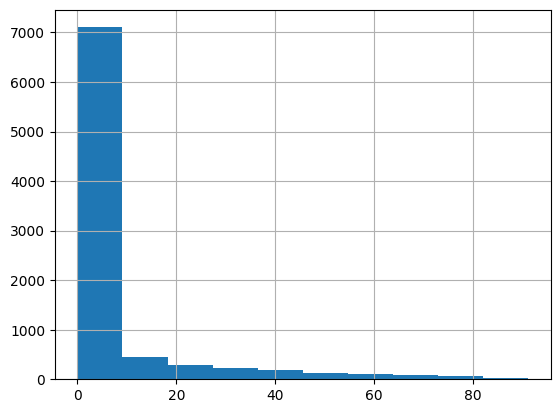

In [46]:
sub.extent.hist()

In [49]:
sub.to_csv(f'sub_{CONF.model_name}_cv{10.89}5folds.csv',index=False)

In [ ]:
from IPython.display import FileLink
FileLink(f'sub_{CONF.model_name}_cv{sc}.csv')

